In [1]:
import unittest
import numpy as np
import treecorr
import healpy as hp
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time 
import os
import coord
from numba import jit, njit


sys.path.insert(1,'../src/')

from CosmoFuse.correlations import Correlation_CPU
from CosmoFuse.utils import pixel2RaDec

In [2]:
nside = 512
radius_patch = 90/60
radius_filter = 5 * radius_patch
theta_Q = np.radians(radius_filter)
nbins = 10
n_patches = 992
des_map = hp.read_map("./data/DESY3_Mask.fits")


map_inds = np.where(des_map!=0)[0]
phi_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_phi.dat")[:n_patches]
theta_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_theta.dat")[:n_patches]


npix = hp.nside2npix(nside)

mintheta = 20
maxtheta = 170

mintheta = mintheta/60/180*np.pi
maxtheta = maxtheta/60/180*np.pi

shear_maps = np.load("./data/shear_maps.npy")        

min_theta = 20
max_theta = 170

w = np.ones_like(shear_maps[0,0])

binedges=np.geomspace(min_theta,max_theta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))

binedges=np.geomspace(mintheta,maxtheta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))/np.pi*180*60

In [3]:
%%time
xip_treecorr = np.zeros((n_patches,nbins))
xim_treecorr = np.zeros((n_patches,nbins))


correlation = treecorr.GGCorrelation(nbins=nbins, min_sep=min_theta, max_sep=max_theta, sep_units='arcmin', brute=True, metric='Arc', bin_slop=0.)
for i in range(n_patches):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    g11 = shear_maps[0,0,pix_inds]
    g21 = shear_maps[0,1,pix_inds]
    #g12 = shear_maps[1,0,pix_inds]
    #g22 = shear_maps[1,1,pix_inds]
    ra, dec = pixel2RaDec(pix_inds, nside)
    catalog1 = treecorr.Catalog(ra=ra, dec=dec, g1=g11, g2=g21, ra_units='rad', dec_units='rad', flip_g1=True)
    #catalog2 = treecorr.Catalog(ra=ra, dec=dec, g1=g12, g2=g22, ra_units='rad', dec_units='rad', flip_g1=True)
    correlation.process(catalog1)
    xip_treecorr[i,:] = correlation.xip
    xim_treecorr[i,:] = correlation.xim
    
rnom = correlation.rnom

CPU times: user 3h 29min 42s, sys: 1.69 s, total: 3h 29min 43s
Wall time: 1min 49s


In [4]:
%%time
corr = Correlation_CPU(nside, phi_center, theta_center, nbins=nbins, patch_size=radius_patch*60, theta_min=min_theta, theta_max=max_theta, mask=des_map, fastmath=False)
corr.load_maps(shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1], w, w, flip_g1=True)

CPU times: user 254 ms, sys: 11.9 ms, total: 266 ms
Wall time: 36.7 ms


In [5]:
%%time
recalc=False
if recalc:
    corr.calculate_pairs_2PCF(threads=10)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 37.2 µs


In [6]:
if recalc:
    corr.save_pairs("../temp/2PCF_pairs.h5")
else:
    corr.load_pairs("../temp/2PCF_pairs.h5")

_ = corr.calculate_2PCF(threads=1)

In [7]:
%%time
xip_corr, xim_corr = corr.calculate_2PCF(threads=1)

CPU times: user 2.25 s, sys: 131 ms, total: 2.38 s
Wall time: 2.38 s


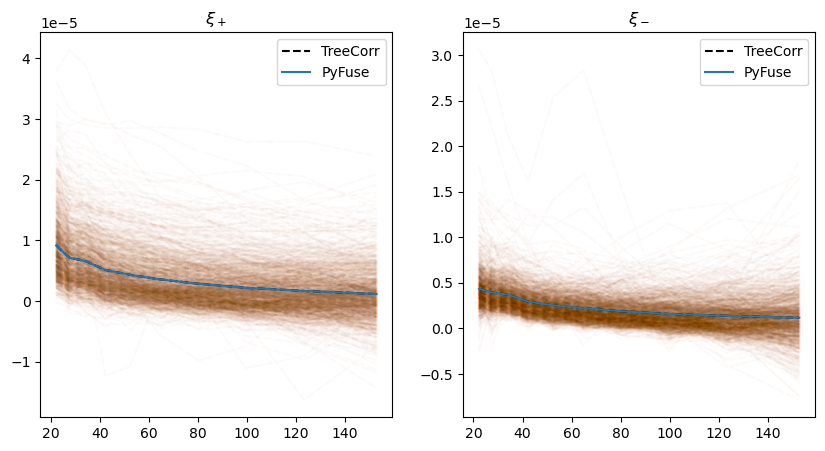

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(n_patches):
    ax[0].plot(rnom, xip_treecorr[i], c='k', ls='--', alpha=.01)
    ax[0].plot(rnom, xip_corr[i], c='C1', alpha=.01)
ax[0].plot(rnom, xip_treecorr.mean(axis=0), c='k', ls='--', label="TreeCorr")
ax[0].plot(rnom, xip_corr.mean(axis=0), c='C0', label="PyFuse")
ax[0].set_title(r"$\xi_+$")
ax[0].legend()

for i in range(n_patches):
    ax[1].plot(rnom, xim_treecorr[i], c='k', ls='--', alpha=.01)
    ax[1].plot(rnom, xim_corr[i], c='C1', alpha=.01)
ax[1].plot(rnom, xim_treecorr.mean(axis=0), c='k', ls='--', label="TreeCorr")
ax[1].plot(rnom, xim_corr.mean(axis=0), c='C0', label="PyFuse")
ax[1].set_title(r"$\xi_-$")
ax[1].legend()


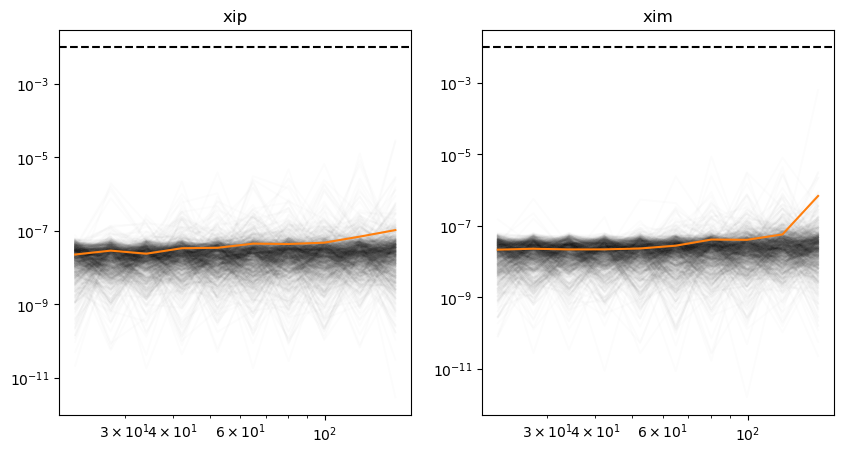

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(n_patches):
    ax[0].loglog(rnom, np.abs(1-(xip_corr/xip_treecorr))[i], label="test", c='k', alpha=.01)
ax[0].loglog(rnom, np.abs(1-(xip_corr/xip_treecorr)).mean(axis=0), c='C1', label="Corr")
ax[0].axhline(0.01, ls='--', c='k')
ax[0].set_title("xip")

for i in range(n_patches):
    ax[1].loglog(rnom, np.abs(1-(xim_corr/xim_treecorr))[i], label="test", c='k', alpha=.01)
ax[1].loglog(rnom, np.abs(1-(xim_corr/xim_treecorr)).mean(axis=0), c='C1', label="Corr")
ax[1].axhline(0.01, ls='--', c='k')
_=ax[1].set_title("xim")

In [11]:
shear_maps.shape

(2, 2, 3145728)